## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 10 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.8]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 12s 239us/step - loss: 1.4850 - accuracy: 0.4800 - val_loss: 1.6553 - val_accuracy: 0.4236
Epoch 6/10
50000/50000 [==============================] - 12s 238us/step - loss: 1.4403 - accuracy: 0.4961 - val_loss: 1.5862 - val_accuracy: 0.4478
Epoch 7/10
50000/50000 [==============================] - 12s 234us/step - loss: 1.4012 - accuracy: 0.5114 - val_loss: 1.5707 - val_accuracy: 0.4427
Epoch 8/10
50000/50000 [==============================] - 12s 231us/step - loss: 1.3671 - accuracy: 0.5237 - val_loss: 1.5275 - val_accuracy: 0.4602
Epoch 9/10
50000/50000 [==============================] - 12s 236us/step - loss: 1.3338 - accuracy: 0.5333 - val_loss: 1.5021 - val_accuracy: 0.4696
Epoch 10/10
50000/50000 [==============================] - 12s 237us/step - loss: 1.3029 - accuracy: 0.5467 - val_loss: 1.4967 - val_accuracy: 0.4700
Numbers of exp: 3, reduce_factor: 0.80, reduce_patient: 10
Model: "model_4"
________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 167us/step - loss: 1.7886 - accuracy: 0.3699 - val_loss: 4.2888 - val_accuracy: 0.1997
Epoch 2/10
50000/50000 [==============================] - 8s 156us/step - loss: 1.5341 - accuracy: 0.4533 - val_loss: 2.0559 - val_accuracy: 0.3251
Epoch 3/10
50000/50000 [==============================] - 8s 159us/step - loss: 1.4462 - accuracy: 0.4859 - val_loss: 1.6107 - val_accuracy: 0.4223
Epoch 4/10
50000/50000 [==============================] - 8s 158us/step - loss: 1.3918 - accuracy: 0.5049 - val_loss: 1.7346 - val_accuracy: 0.3874
Epoch 5/10
50000/50000 [==============================] - 8s 160us/step - loss: 1.3376 - accuracy: 0.5228 - val_loss: 1.5901 - val_accuracy: 0.4355
Epoch 6/10
50000/50000 [==============================] - 8s 155us/step - loss: 1.2807 - accuracy: 0.5474 - val_loss: 1.5591 - val_accuracy: 0.4529
Epoch 7/10
50000/50000 [==============================] - 8s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 152us/step - loss: 1.8024 - accuracy: 0.3754 - val_loss: 2.0928 - val_accuracy: 0.2400
Epoch 2/10
50000/50000 [==============================] - 7s 139us/step - loss: 1.5396 - accuracy: 0.4555 - val_loss: 2.0635 - val_accuracy: 0.2751
Epoch 3/10
50000/50000 [==============================] - 7s 138us/step - loss: 1.4341 - accuracy: 0.4929 - val_loss: 1.7931 - val_accuracy: 0.3561
Epoch 4/10
50000/50000 [==============================] - 7s 141us/step - loss: 1.3591 - accuracy: 0.5180 - val_loss: 1.8693 - val_accuracy: 0.3412
Epoch 5/10
50000/50000 [==============================] - 7s 141us/step - loss: 1.2996 - accuracy: 0.5401 - val_loss: 1.6941 - val_accuracy: 0.3809
Epoch 6/10
50000/50000 [==============================] - 7s 139us/step - loss: 1.2448 - accuracy: 0.5595 - val_loss: 1.9106 - val_accuracy: 0.3417
Epoch 7/10
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 149us/step - loss: 1.7798 - accuracy: 0.3834 - val_loss: 1.9590 - val_accuracy: 0.2997
Epoch 2/10
50000/50000 [==============================] - 7s 140us/step - loss: 1.5106 - accuracy: 0.4695 - val_loss: 1.8174 - val_accuracy: 0.3452
Epoch 3/10
50000/50000 [==============================] - 7s 141us/step - loss: 1.4051 - accuracy: 0.5034 - val_loss: 1.8465 - val_accuracy: 0.3416
Epoch 4/10
50000/50000 [==============================] - 7s 141us/step - loss: 1.3327 - accuracy: 0.5312 - val_loss: 1.7581 - val_accuracy: 0.3773
Epoch 5/10
50000/50000 [==============================] - 7s 145us/step - loss: 1.2708 - accuracy: 0.5518 - val_loss: 1.7556 - val_accuracy: 0.3890
Epoch 6/10
50000/50000 [==============================] - 7s 144us/step - loss: 1.2247 - accuracy: 0.5680 - val_loss: 1.8286 - val_accuracy: 0.3767
Epoch 7/10
50000/50000 [==============================] - 7s 1

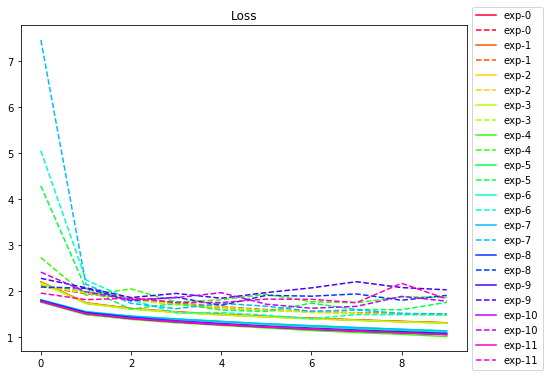

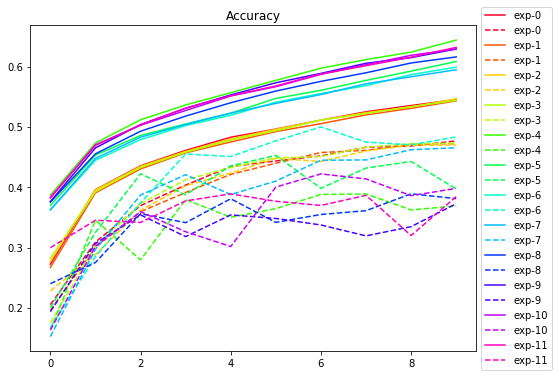

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()